In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
import shutil

## Downloading the data

In [2]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/hourly-breakout-patterns")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 26.3M/26.3M [00:00<00:00, 70.0MB/s]

Extracting files...


Renamed downloaded file to 'output_latest.zip'


## Getting the data ready for the machine learning model

In [3]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Directories
original_train_dir = '/content/output_latest.zip/output_hourly_breakout_patterns/train'
original_test_dir = '/content/output_latest.zip/output_hourly_breakout_patterns/test'
balanced_train_dir = "balanced_train_dir"
balanced_test_dir = "balanced_test_dir"

# Helper function to balance classes
def balance_classes(original_dir, balanced_dir):
    # Get class distributions
    class_counts = {cls: len(os.listdir(os.path.join(original_dir, cls))) for cls in os.listdir(original_dir)}
    print(f"Class distribution in {original_dir}: {class_counts}")

    # Find the minimum number of samples (for the minority class)
    min_samples = min(class_counts.values())

    # Create balanced directory
    if not os.path.exists(balanced_dir):
        os.makedirs(balanced_dir)

    for cls in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, cls)
        balanced_class_dir = os.path.join(balanced_dir, cls)

        if not os.path.exists(balanced_class_dir):
            os.makedirs(balanced_class_dir)

        # Get all image file paths
        all_images = os.listdir(class_dir)
        random.shuffle(all_images)

        # Copy only min_samples images to the balanced directory
        for img in all_images[:min_samples]:
            shutil.copy(os.path.join(class_dir, img), os.path.join(balanced_class_dir, img))

# Balance training and test datasets
balance_classes(original_train_dir, balanced_train_dir)
balance_classes(original_test_dir, balanced_test_dir)

# Create balanced train dataset
train_ds = tf_keras.utils.image_dataset_from_directory(
    directory=balanced_train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

# Create balanced test dataset
test_ds = tf_keras.utils.image_dataset_from_directory(
    directory=balanced_test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = train_ds.class_names
print("Balanced datasets created successfully!")

Class distribution in /content/output_latest.zip/output_hourly_breakout_patterns/train: {'no_breakout': 7944, 'bullish_breakout': 344, 'false_bullish_breakout': 125, 'false_bearish_breakout': 116, 'bearish_breakout': 309}
Class distribution in /content/output_latest.zip/output_hourly_breakout_patterns/test: {'no_breakout': 2025, 'bullish_breakout': 82, 'false_bullish_breakout': 45, 'false_bearish_breakout': 34, 'bearish_breakout': 71}
Found 580 files belonging to 5 classes.
Found 170 files belonging to 5 classes.
Balanced datasets created successfully!


In [4]:
AUTOTUNE = tf.data.AUTOTUNE # let TensorFlow find the best values to use automatically

# Shuffle and optimize performance on training datasets
# Note: these methods can be chained together and will have the same effect as calling them individually
train_ds = train_ds.cache().shuffle(buffer_size=100*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Don't need to shuffle test datasets (for easier evaluation)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building the machine learning model

In [6]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [7]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      activation (str, optional): Activation function for the output layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  # Create base model
  base_model = tf_keras.applications.ConvNeXtXLarge(
      include_top=include_top,
      weights="imagenet",
      input_shape=input_shape,
      include_preprocessing=include_preprocessing,
      pooling="max"  # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
  )

  if activation == "softmax":
    activation = tf_keras.activations.softmax
  elif activation == "sigmoid":
    activation = tf_keras.activations.sigmoid

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(
      units=num_classes,
      activation=activation,
      name="output_layer"
  )(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  return model

## Training model (Fine Tuned)

In [9]:
# 1. Create a model

model_0 = create_model(num_classes=len(class_names), trainable=False)

count_parameters(model=model_0, print_output=True)

# 2. Compile the model
model_0.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])

# Define the EarlyStopping callback
early_stopping = tf_keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=5,              # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# 3. Fit the model
epochs = 1000
history_0 = model_0.fit(
    x=train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[early_stopping]
)

# Save the weights as a .keras file
weights_save_path = "model_0_weights_fine_tuened.keras"

# Save only the weights
model_0.save_weights(weights_save_path, save_format="h5")
print(f"Weights saved to {weights_save_path}")

Model model parameter counts:
Total parameters: 348158213
Trainable parameters: 10245
Non-trainable parameters: 348147968
Epoch 1/1000
19/19 [==============================] - 30s 797ms/step - loss: 1.7072 - accuracy: 0.3224 - val_loss: 1.2723 - val_accuracy: 0.4882
Epoch 2/1000
19/19 [==============================] - 4s 240ms/step - loss: 1.1927 - accuracy: 0.5517 - val_loss: 1.1399 - val_accuracy: 0.5353
Epoch 3/1000
19/19 [==============================] - 5s 242ms/step - loss: 0.9429 - accuracy: 0.6431 - val_loss: 1.0108 - val_accuracy: 0.5882
Epoch 4/1000
19/19 [==============================] - 5s 243ms/step - loss: 0.8388 - accuracy: 0.6931 - val_loss: 0.9820 - val_accuracy: 0.6529
Epoch 5/1000
19/19 [==============================] - 4s 210ms/step - loss: 0.7806 - accuracy: 0.7172 - val_loss: 0.9051 - val_accuracy: 0.6471
Epoch 6/1000
19/19 [==============================] - 5s 242ms/step - loss: 0.7030 - accuracy: 0.7448 - val_loss: 0.8925 - val_accuracy: 0.6706
Epoch 7/1000


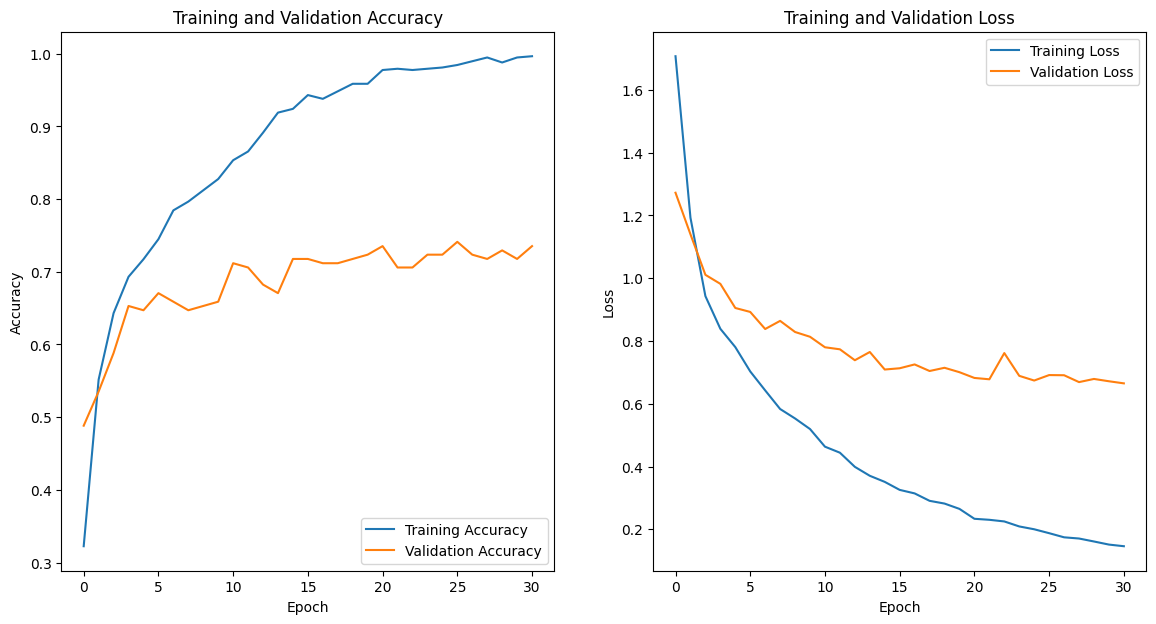

In [10]:
def plot_model_loss_curves(history: tf.keras.callbacks.History) -> None:
  """Takes a History object and plots loss and accuracy curves."""

  # Get the accuracy values
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  # Get the loss values
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  # Get the number of epochs
  epochs_range = range(len(acc))

  # Create accuracy curves plot
  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  # Create loss curves plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

plot_model_loss_curves(history=history_0)